# CO2 Emissions Prediction

## Table of Contents
1. [Introduction](#introduction)
2. [Requirements](#Requirements)
3. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
4. [Feature Engineering](#feature-engineering)
5. [Model Training](#model-training)

   5.1 [LightGBM Model](#lightgbm-model)
   
   5.2 [CatBoost Model](#catboost-model)
6. [Ensemble](#ensemble)
7. [Results and Submission](#results-and-submission)

## Introduction
This notebook contains the code for predicting CO2 emissions using satellite data. This model achieved second place in the competition.



# Requirements

sklearn version == 1.2.2
catboost version == 1.2.5

In [2]:
!pip install -q lightgbm==3.3.5
!pip install -q catboost

## Data Loading and Preprocessing

LOADING THE LIBRARIES

In [3]:
# Import required libraries
import os, sys, gc, warnings, random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
import lightgbm as lgb
import catboost as catt
import xgboost as xgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

# Suppress warnings for cleaner output
import warnings
warnings.simplefilter('ignore')

# Additional imports for custom transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

verifying requirements

In [4]:
import lightgbm
print(lightgbm.__version__)

3.3.5


In [5]:
import catboost
print(catboost.__version__)

1.2.5


In [6]:
import sklearn
print(sklearn.__version__)

1.2.2


LOADING THE DATA FROM KAGGLE DIRECTORY

In [7]:


path = '/kaggle/working/'


In [10]:
train = pd.read_csv('/kaggle/input/train-1/Trai.csv')
test = pd.read_csv('/kaggle/input/test-1/Test.csv')

REDUCING MEMORY FUNCTION

In [11]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')

        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)

    return df

In [12]:
train = convert_types(train)
test = convert_types(test)

REMOVING NANS WITH MISSING VALUES GREATER THAN THE THRESH

In [13]:
def remove_nans(train,thresh) :
  def nans_rate(train,col) :
    return train[col].isna().sum() / train.shape[0]

  for col in train.columns :
    if nans_rate(train,col) >= thresh :
      train.drop(col,axis=1,inplace=True)
  return train

In [14]:
train = remove_nans(train,thresh=0.8)
test = test[train.columns[:-1]]

In [15]:
train.shape, test.shape

((74005, 69), (28085, 68))

## Feature Engineering

Feature engineering played a crucial role in the success of my CO2 emissions prediction model. Here's an in-depth look at each step of my feature engineering process:

### 1. Location Feature Creation

I created a composite location feature by combining latitude and longitude:

```python
data['location'] = [str(x) + '_' + str(y) for x, y in zip(data.latitude, data.longitude)]
```

This feature allows my model to capture location-specific patterns in CO2 emissions. By encoding the geographic information into a single feature, I enable the model to learn location-dependent relationships more effectively.

### 2. Month Feature Extraction

I extracted a month feature from the year and week number:

```python
def getMonth(year: int, week: int) -> int:
    return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").month

data['month'] = data.apply(lambda x: getMonth(x['year'], x['week_no']), axis=1)
```

This feature is particularly useful for cross-validation, as it allows me to stratify my folds based on the month. This stratification helps ensure that my model's performance is consistent across different months, capturing potential seasonal variations in CO2 emissions.

### 3. Removal of Low-Correlation Features

I dropped all angle, altitude, depth, and height columns due to their low correlation with the target variable:

```python
angle_cols = [col for col in data.columns if 'angle' in col or 'altitude' in col or 'depth' in col or 'height' in col]
data = data.drop(columns=angle_cols)
```

This step helps reduce noise in my dataset and focuses the model on more relevant features, potentially improving its performance and reducing overfitting.

### 4. Cyclical Features

To capture the cyclical nature of time-based features, I created trigonometric and periodic spline-based features:

```python
data["month_sin"] = sin_transformer(12).fit_transform(data["month"])
data["month_cos"] = cos_transformer(12).fit_transform(data["month"])

spline_cols_month = [f"cyclic_month_spline_{i}" for i in range(1, 7)]
data[spline_cols_month] = periodic_spline_transformer(12, n_splines=6).fit_transform(np.array(data.month).reshape(-1,1))
```

These features allow my model to understand the cyclical patterns in CO2 emissions that may be related to seasonal changes. The combination of sine, cosine, and spline transformations provides a rich representation of cyclical patterns. I was inspired to use this approach by David Nkosana's winning notebook in the Air Quality competition.

### 5. Rolling Statistics

I created rolling means, max, min, sum, standard deviation, and skewness for windows of 17, 39, and 52 weeks:

```python
for col in shift_cols:
    data[f"{col}_rolling_mean_39"] = data[col].rolling(window=39).mean()
    data[f"{col}__rolling_max_39"] = data[col].rolling(window=39).max()
    # ... (similar for other statistics and window sizes)
```

These rolling statistics capture trends and patterns over different time scales. I chose the 17, 39, and 52-week windows to capture short-term, medium-term, and annual trends respectively. This helps my model understand both recent and long-term patterns in CO2 emissions, which I observed in my EDA notebook.

### 6. Location-Based Statistics

I computed various statistics (mean, std, min, max, skew) grouped by location:

```python
for col in shift_cols:
    data[f"{col}__location_mean"] = data.groupby(['location'])[col].transform('mean')
    data[f"{col}__location_std"] = data.groupby(['location'])[col].transform('std')
    # ... (similar for other statistics)
```

This was the golden feature in my model. My reasoning behind this approach was that while the test and train sets come from different distributions (different provinces), locations with similar statistical profiles in terms of other features are likely to have similar CO2 emission patterns. This helps my model generalize across different geographic areas.

### 7. Dropping Redundant Features

Finally, I dropped the original latitude, longitude, and location features:

```python
data = data.drop(columns=['longitude', 'latitude', 'location'])
```

I took this step to address the different distributions between the train and test sets. By removing these direct geographic identifiers and relying instead on the derived location-based statistics, I help my model focus on patterns that are more likely to generalize across different regions.

### Conclusion

This extensive feature engineering process was crucial to my model's success. By creating rich, informative features that capture various aspects of the data - from geographic patterns to temporal trends - I provided my model with a strong foundation for accurate CO2 emission predictions. The combination of domain knowledge (understanding the importance of location and time in emissions) with data-driven approaches (like using rolling statistics and location-based aggregations) proved to be a powerful strategy in this competition, helping me secure second place.

In [16]:
def process(train , test) :
    data = pd.concat([train,test])
    data.latitude, data.longitude = round(data.latitude, 2), round(data.longitude, 2)
    data['location'] = [str(x) + '_' + str(y) for x, y in zip(data.latitude, data.longitude)]
    data = data.sort_values(by = ['location', 'year', 'week_no'])
    angle_cols = [col for col in data.columns if 'angle' in col or 'altitude' in col or 'depth' in col or 'height' in col]
    shift_cols = [col for col in data.columns if col not in angle_cols + ['ID_LAT_LON_YEAR_WEEK','year_week','longitude','latitude','emission','year_month','month','latitude','longitude' 'location','location','bin','year','week_no',]]
    def sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period *2 * np.pi))

    def cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    def periodic_spline_transformer(period, n_splines=None, degree=3):
        if n_splines is None:
            n_splines = period
        n_knots = n_splines + 1 # periodoc and include bias = True
        return SplineTransformer(degree=degree,
                                n_knots=n_knots,
                                knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
                                extrapolation="periodic",
                                include_bias=True)

    def getMonth(year: int, week: int) -> int:

        """Return the month number in the given week in the given year."""
        return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").month
    data['month'] = data.apply(lambda x: getMonth(x['year'], x['week_no']), axis=1)


        # Extract trigonometric features
    data["month_sin"] = sin_transformer(12).fit_transform(data["month"])
    data["month_cos"] = cos_transformer(12).fit_transform(data["month"])



    # Extract periodic spline-based features
    spline_cols_month = [f"cyclic_month_spline_{i}" for i in range(1, 7)]


    data[spline_cols_month] = periodic_spline_transformer(12, n_splines=6).fit_transform(np.array(data.month).reshape(-1,1))








    for col in shift_cols:
        data[f"{col}_rolling_mean_39"] = data[col].rolling(window=39).mean()
        data[f"{col}__rolling_max_39"] = data[col].rolling(window=39).max()
        data[f"{col}__rolling_min_39"] = data[col].rolling(window=39).min()
        data[f"{col}__rolling_sum_39"] = data[col].rolling(window=39).sum()
        data[f"{col}__rolling_std_39"] = data[col].rolling(window=39).std()
        data[f"{col}__rolling_skew_39"] = data[col].rolling(window=39).skew()

        data[f"{col}_rolling_mean_52"] = data[col].rolling(window=52).mean()
        data[f"{col}__rolling_max_52"] = data[col].rolling(window=52).max()
        data[f"{col}__rolling_min_52"] = data[col].rolling(window=52).min()
        data[f"{col}__rolling_sum_52"] = data[col].rolling(window=52).sum()
        data[f"{col}__rolling_std_52"] = data[col].rolling(window=52).std()
        data[f"{col}__rolling_skew_52"] = data[col].rolling(window=52).skew()

        data[f"{col}_rolling_mean"] = data[col].rolling(window=17).mean()
        data[f"{col}__rolling_max"] = data[col].rolling(window=17).max()
        data[f"{col}__rolling_min"] = data[col].rolling(window=17).min()
        data[f"{col}__rolling_sum"] = data[col].rolling(window=17).sum()
        data[f"{col}__rolling_std"] = data[col].rolling(window=17).std()
        data[f"{col}__rolling_skew"] = data[col].rolling(window=17).skew()





        data[f"{col}__location_mean"] = data.groupby(['location'])[col].transform('mean')
        data[f"{col}__location_std"] = data.groupby(['location'])[col].transform('std')
        data[f"{col}__location_min"] = data.groupby(['location'])[col].transform('min')
        data[f"{col}__location_max"] = data.groupby(['location'])[col].transform('max')
        data[f"{col}__location_skew"] = data.groupby(['location'])[col].transform('skew')



    for col in ['location']:
        data[col] = le.fit_transform(data[col])

    data = data.drop(columns = angle_cols + ['longitude','latitude'])











    train = data[data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]

    test = data[~data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]



    return train , test

In [17]:
train , test = process(train , test)

In [18]:
train.shape, test.shape

((74005, 686), (28085, 686))

In [19]:
display(train.head(), test.head())

,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.73_28.77_2019_1,2019,1,0.000167,0.713379,0.000102,0.223877,0.000033,0.023407,2830.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
1,ID_-23.73_28.77_2019_2,2019,2,-0.000155,0.812988,-0.000137,0.080261,-0.000067,0.024185,2136.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
2,ID_-23.73_28.77_2019_3,2019,3,-0.000065,0.860352,-0.000062,0.161011,-0.000031,0.023697,1908.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
3,ID_-23.73_28.77_2019_4,2019,4,0.000152,0.422363,0.000087,0.046509,0.000031,0.022354,2122.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
4,ID_-23.73_28.77_2019_5,2019,5,0.000024,1.004883,0.000028,0.214233,0.000005,0.023041,1750.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532


,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.53_27.47_2019_1,2019,1,0.000077,0.454590,0.000034,0.114319,0.000015,0.025940,2344.0,...,NaN,NaN,NaN,NaN,NaN,0.218877,0.054245,0.12561,0.373779,0.565436
1,ID_-23.53_27.47_2019_2,2019,2,0.000181,0.423096,0.000062,0.075073,0.000024,0.025040,2188.0,...,NaN,NaN,NaN,NaN,NaN,0.218877,0.054245,0.12561,0.373779,0.565436
2,ID_-23.53_27.47_2019_3,2019,3,0.000059,0.712891,0.000043,0.114197,0.000020,0.025024,2314.0,...,NaN,NaN,NaN,NaN,NaN,0.218877,0.054245,0.12561,0.373779,0.565436
3,ID_-23.53_27.47_2019_4,2019,4,0.000483,0.434570,0.000171,0.131348,0.000068,0.022354,2068.0,...,NaN,NaN,NaN,NaN,NaN,0.218877,0.054245,0.12561,0.373779,0.565436
4,ID_-23.53_27.47_2019_5,2019,5,0.000193,0.783203,0.000141,0.161133,0.000065,0.023575,1995.0,...,NaN,NaN,NaN,NaN,NaN,0.218877,0.054245,0.12561,0.373779,0.565436


In [20]:
train = train.sort_values(by = ['location','year','week_no'])
test = test.sort_values(by = ['location','year','week_no'])
train.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.73_28.77_2019_1,2019,1,0.000167,0.713379,0.000102,0.223877,0.000033,0.023407,2830.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
1,ID_-23.73_28.77_2019_2,2019,2,-0.000155,0.812988,-0.000137,0.080261,-0.000067,0.024185,2136.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
2,ID_-23.73_28.77_2019_3,2019,3,-0.000065,0.860352,-0.000062,0.161011,-0.000031,0.023697,1908.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
3,ID_-23.73_28.77_2019_4,2019,4,0.000152,0.422363,0.000087,0.046509,0.000031,0.022354,2122.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532
4,ID_-23.73_28.77_2019_5,2019,5,0.000024,1.004883,0.000028,0.214233,0.000005,0.023041,1750.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.859532


In [21]:
# Selecting the independent variables and the target variable
X = train.drop(['ID_LAT_LON_YEAR_WEEK','emission','location'], axis = 1).fillna(0)
y = train.emission



## Model Training

### LightGBM Model
I used LightGBM with StratifiedKFold cross-validation for our first model.

MODELLING USING STRATIFIED KFOLD
* I used Month column because , In my EDA I found that other than different locations, the test and train were splitted according to the Month


In [22]:
fold_pred = []
oof_pred = []

params1 = {
    'learning_rate': 0.15592472218053005,
    'subsample': 0.9072713541530352,
    'colsample_bytree': 0.5062834624362592,
    'max_depth': 12,
    'objective': 'rmse'
}

fold = StratifiedKFold(n_splits=12)
i = 1

for train_index, test_index in fold.split(X, X['month']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = lgb.LGBMRegressor(**params1, n_estimators=3050)

    model.fit(X_train,y_train,eval_set=[(X_test ,y_test)], early_stopping_rounds=120, verbose = 250)#erly100

    preds= model.predict(X_test,num_iteration=model.best_iteration_ )
    print("rmse: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds), squared=False))
    p2 = model.predict(test[X.columns],num_iteration=model.best_iteration_)
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=120),
#             lgb.log_evaluation(period=250)
#         ]
#     )

#     preds = model.predict(X_test, num_iteration=model.best_iteration_)
#     print(f"Fold {i} RMSE: {mean_squared_error(y_test, np.expm1(preds), squared=False)}")
#     oof_pred.append(mean_squared_error(y_test, np.expm1(preds), squared=False))

#     p2 = model.predict(test[X.columns], num_iteration=model.best_iteration_)
#     fold_pred.append(np.expm1(p2))

#     i += 1

# print(f"Mean RMSE across all folds: {np.mean(oof_pred)}")

err:  2548.776687280071
err:  1806.7255218495852
[250]	valid_0's rmse: 4635.87
err:  2988.8259046931435
[250]	valid_0's rmse: 181238
err:  175326.76145258543
[250]	valid_0's rmse: 22843.4
[500]	valid_0's rmse: 22843.4
err:  13474.460191903612
[250]	valid_0's rmse: 3018.95
err:  2381.222587934905
err:  1503.589788720579
err:  7568.034619159251
err:  4472.291230791394
[250]	valid_0's rmse: 17627.1
err:  12415.44632936257
err:  2008.4887968693322
err:  8826.91653581981
19610.128303914138


err:  2548.776687280071

err:  1806.7255218495852

[250]	valid_0's rmse: 4635.87

err:  2988.8259046931435

[250]	valid_0's rmse: 181238

err:  175326.76145258543

[250]	valid_0's rmse: 22843.4

[500]	valid_0's rmse: 22843.4

err:  13474.460191903612

[250]	valid_0's rmse: 3018.95

err:  2381.222587934905

err:  1503.589788720579

err:  7568.034619159251

err:  4472.291230791394

[250]	valid_0's rmse: 17627.1

err:  12415.44632936257

err:  2008.4887968693322

err:  8826.91653581981

19610.128303914138


20350.844524786546 - 19206.162602812623 - 18815

Text(0.5, 1.0, 'Lightgbm features importance (top 50):')

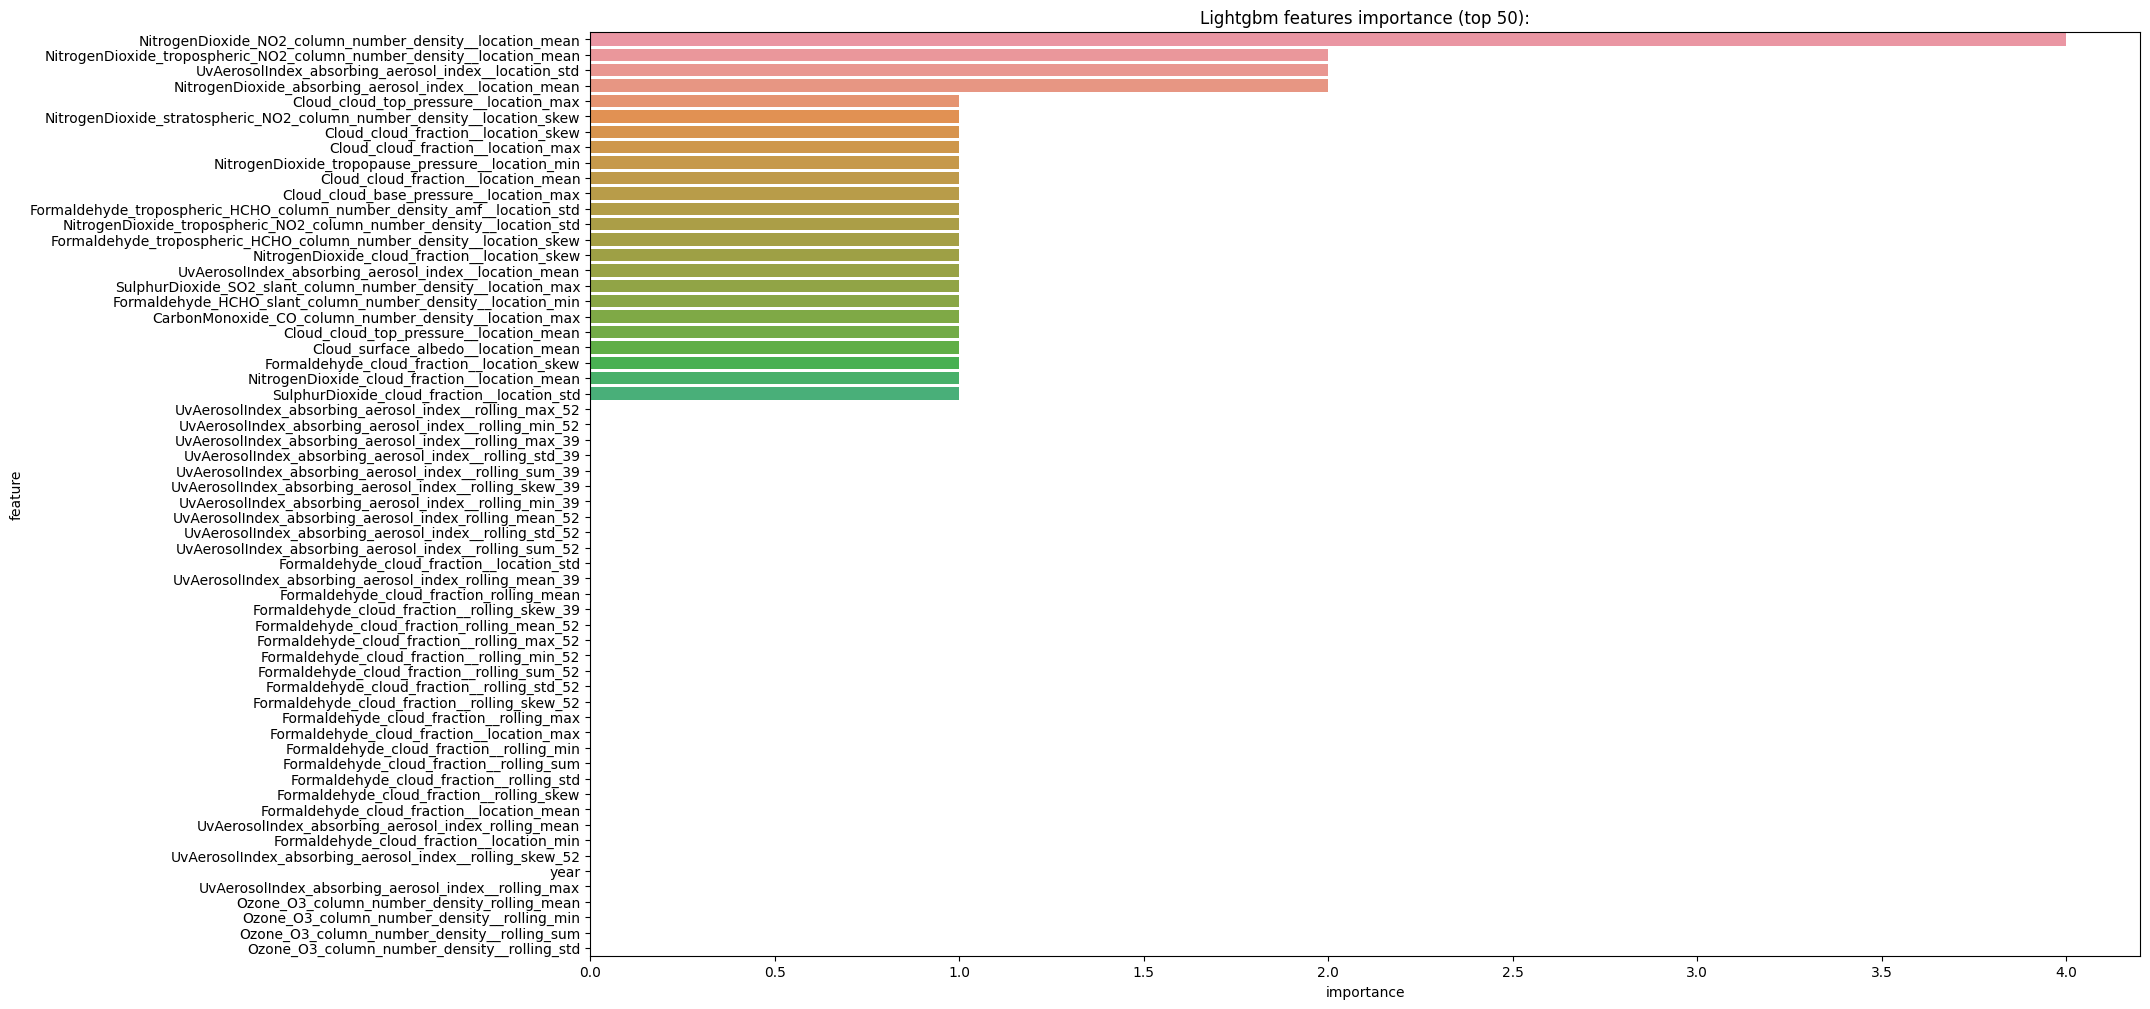

In [23]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Lightgbm features importance (top 50):')

In [24]:
preds = np.mean(fold_pred,axis=0)
subb = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test['ID_LAT_LON_YEAR_WEEK'],
    'target': preds
})


subb.target.describe()

count    28085.000000
mean      3323.666617
std       3441.020057
min        257.450547
25%        883.316184
50%       2179.580420
75%       4291.150056
max      20565.830166
Name: target, dtype: float64

In [25]:
subb.to_csv(path + 'lgbModel.csv', index = False)

### CatBoost Model
My second model is a CatBoost regressor trained on the entire dataset.

In [27]:
import catboost as catt
cb_model = catt.CatBoostRegressor(iterations=5000,
                             learning_rate=0.045,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                            bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=300)
cb_model.fit(X, y,
             use_best_model=True,
             verbose=2000)


# import numpy as np
# import pandas as pd
# import catboost as catt

# # First, let's check for and handle NaN values in both X and y
# print("NaN values in X:", X.isna().sum().sum())
# print("NaN values in y:", y.isna().sum())

# # Remove rows with NaN values in either X or y
# data = pd.concat([X, y], axis=1)
# data_cleaned = data.dropna()
# X_cleaned = data_cleaned.drop(y.name, axis=1)
# y_cleaned = data_cleaned[y.name]

# print("Shape before cleaning:", X.shape, y.shape)
# print("Shape after cleaning:", X_cleaned.shape, y_cleaned.shape)

# # Now, let's create and fit the model
# cb_model = catt.CatBoostRegressor(iterations=5000,
#                                   learning_rate=0.045,
#                                   depth=8,
#                                   eval_metric='RMSE',
#                                   random_seed=42,
#                                   bagging_temperature=0.2,
#                                   od_type='Iter',
#                                   metric_period=50,
#                                   od_wait=300)

# cb_model.fit(X_cleaned, y_cleaned,
#              use_best_model=True,
#              verbose=2000)

print("Model fitting completed.")

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 50430.2611114	total: 566ms	remaining: 47m 7s
2000:	learn: 274.5276586	total: 13m 41s	remaining: 20m 31s
4000:	learn: 145.5050850	total: 27m 39s	remaining: 6m 54s
4999:	learn: 116.8912786	total: 34m 30s	remaining: 0us
Model fitting completed.


In [28]:
preds = (cb_model.predict(test[X.columns]))

prediction = preds
prediction[prediction < 0] = 0

submission = pd.DataFrame()
submission['ID_LAT_LON_YEAR_WEEK'] = test['ID_LAT_LON_YEAR_WEEK']
submission['target'] = prediction
submission.to_csv(path + "CatBoostModel.csv", index=False)
submission.head()



,ID_LAT_LON_YEAR_WEEK,target
0,ID_-23.53_27.47_2019_1,5981.134469
1,ID_-23.53_27.47_2019_2,5689.946395
2,ID_-23.53_27.47_2019_3,7300.984364
3,ID_-23.53_27.47_2019_4,7071.253431
4,ID_-23.53_27.47_2019_5,7194.100878


## Ensemble
I created a simple average ensemble of our LightGBM and CatBoost models.

* this does the trick!

In [30]:
import pandas as pd
cat = pd.read_csv(path + 'CatBoostModel.csv')
light = pd.read_csv(path + 'lgbModel.csv')

ensemble = light.copy()

ensemble['target'] = light['target']*0.5  + cat['target']*0.5

ensemble.to_csv(path + 'winning_submission4.csv',index=False)
ensemble['target'].describe()



count    28085.000000
mean      6601.473641
std       8108.009259
min        142.987702
25%       1839.342925
50%       3799.806574
75%       6940.477897
max      45054.434493
Name: target, dtype: float64